In [1]:
from matplotlib.colors import LinearSegmentedColormap

# Parula-like RGB list (approximate)
parula_data = [
    [0.2081, 0.1663, 0.5292],
    [0.2116, 0.1898, 0.5777],
    [0.2123, 0.2138, 0.6270],
    [0.2081, 0.2386, 0.6771],
    [0.1959, 0.2645, 0.7279],
    [0.1707, 0.2919, 0.7792],
    [0.1253, 0.3242, 0.8303],
    [0.0591, 0.3598, 0.8683],
    [0.0117, 0.3875, 0.8820],
    [0.0060, 0.4086, 0.8828],
    [0.0165, 0.4266, 0.8786],
    [0.0329, 0.4430, 0.8720],
    [0.0498, 0.4586, 0.8641],
    [0.0629, 0.4737, 0.8554],
    [0.0723, 0.4887, 0.8467],
    [0.0779, 0.5040, 0.8384],
    [0.0793, 0.5200, 0.8312],
    [0.0749, 0.5375, 0.8263],
    [0.0641, 0.5570, 0.8240],
    [0.0488, 0.5772, 0.8228],
    [0.0343, 0.5966, 0.8199],
    [0.0265, 0.6137, 0.8135],
    [0.0239, 0.6287, 0.8038],
    [0.0231, 0.6418, 0.7913],
    [0.0228, 0.6535, 0.7768],
    [0.0267, 0.6642, 0.7607],
    [0.0384, 0.6743, 0.7436],
    [0.0590, 0.6838, 0.7254],
    [0.0843, 0.6928, 0.7062],
    [0.1133, 0.7015, 0.6859],
    [0.1453, 0.7098, 0.6646],
    [0.1801, 0.7177, 0.6424],
    [0.2178, 0.7250, 0.6193],
    [0.2586, 0.7317, 0.5954],
    [0.3022, 0.7376, 0.5712],
    [0.3482, 0.7424, 0.5473],
    [0.3953, 0.7459, 0.5244],
    [0.4420, 0.7481, 0.5033],
    [0.4871, 0.7491, 0.4840],
    [0.5300, 0.7491, 0.4661],
    [0.5709, 0.7485, 0.4494],
    [0.6099, 0.7473, 0.4337],
    [0.6473, 0.7456, 0.4188],
    [0.6834, 0.7435, 0.4044],
    [0.7184, 0.7411, 0.3905],
    [0.7525, 0.7384, 0.3768],
    [0.7858, 0.7356, 0.3633],
    [0.8185, 0.7327, 0.3498],
    [0.8507, 0.7299, 0.3360],
    [0.8824, 0.7274, 0.3217],
    [0.9139, 0.7258, 0.3063],
    [0.9450, 0.7261, 0.2886],
    [0.9739, 0.7314, 0.2666],
    [0.9938, 0.7455, 0.2403],
    [0.9990, 0.7653, 0.2164],
    [0.9955, 0.7861, 0.1967],
    [0.9880, 0.8066, 0.1794],
    [0.9789, 0.8271, 0.1633],
    [0.9697, 0.8481, 0.1475],
    [0.9626, 0.8705, 0.1309],
    [0.9589, 0.8949, 0.1132],
    [0.9598, 0.9218, 0.0948],
    [0.9661, 0.9514, 0.0755],
]

# Create custom colormap
parula_map = LinearSegmentedColormap.from_list("parula", parula_data)




In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from joblib import Parallel, delayed

import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on", device)


Running on cpu


In [3]:
###############################################################################
# System / Simulation Parameters
###############################################################################
N_t = 8       # number of Tx array elements
K   = 16       # number of OFDM subcarriers
M_x = 6       # number of RIS elements along x-axis
M_z = 6       # number of RIS elements along z-axis

beta = 1.0     # complex path gain (set to 1 for simplicity)

# Transmitter angles (degrees)
theta_T = 15
phi_T   = 10

# Communication user angles (degrees)
theta_c = 40
phi_c   = 30

# two communication users:
user_locations = [
    (theta_c, phi_c),   # user1
    (-40, 30),   # user2
    # (0, 30),  # user3
]

# SNR setup (0 dB) - we’ll compute noise variance to match average signal power
SNR_dB  = 0
SNR_lin = 10 ** (SNR_dB / 10.0)
noiseVar = 1.0 / SNR_lin        # average QPSK symbol power = 1
noise_std = np.sqrt(noiseVar / K / 2.0)  # for complex noise


###############################################################################
# Define Helper Functions
###############################################################################

def array_factor_grid(theta_deg, phi_deg, dtype=torch.cfloat):
    """
    PyTorch-compatible array factor:
        a_{mn}(theta, phi) = exp(-j * pi * [m*sin(theta)*cos(phi) + n*sin(theta)*sin(phi)])
    """

    m_idx = torch.arange(M_x, device=device).view(-1, 1)  # shape (M_x, 1)
    n_idx = torch.arange(M_z, device=device).view(1, -1)  # shape (1, M_z)

    theta_rad = torch.deg2rad(torch.tensor(theta_deg, dtype=torch.float32, device=device))
    phi_rad   = torch.deg2rad(torch.tensor(phi_deg, dtype=torch.float32, device=device))

    phase = -1j * torch.pi * (
        m_idx * torch.sin(theta_rad) * torch.cos(phi_rad) +
        n_idx * torch.sin(theta_rad) * torch.sin(phi_rad)
    )  # shape (M_x, M_z), complex

    return torch.exp(phase.to(dtype=dtype))  # shape (M_x, M_z)


###############################################################################
# Building v_ for each user (Toeplitz vector in freq domain)
# This depends on c_{mn}, tau0_{mn}, delta_{mn}, and angles (theta, phi).
##############################################################################
def build_v(theta_deg, phi_deg, c_mat, tau0_mat, delta_mat):
    """
    Vectorized PyTorch function to build v (2K−1)-length complex vector
    for given angles (theta_deg, phi_deg) using TM-IRS parameters.

    Args:
        theta_deg, phi_deg: angles in degrees
        c_mat:     (M_x, M_z) complex tensor
        tau0_mat:  (M_x, M_z) float tensor
        delta_mat: (M_x, M_z) float tensor

    Returns:
        v: complex tensor of shape (2K - 1,)
    """
    v_len = 2 * K - 1

    # Vectorize array factors
    a_tx = array_factor_grid(theta_T, phi_T)
    a_rx = array_factor_grid(theta_deg, phi_deg)

    # Flatten everything
    a_tx = a_tx.reshape(-1)
    a_rx = a_rx.reshape(-1)
    c_flat = c_mat.reshape(-1)
    t0_flat = tau0_mat.reshape(-1)
    d_flat = delta_mat.reshape(-1)

    v = torch.zeros(v_len, dtype=torch.cfloat, device=device)

    for h_idx in range(v_len):
        h = h_idx - (K - 1)

        x = h * d_flat
        sinc = torch.where(
            torch.abs(x) < 1e-6,
            torch.ones_like(x),
            torch.sin(torch.pi * x) / (torch.pi * x)
        )

        phase_arg = -1j * h * torch.pi * (2 * t0_flat + d_flat)
        val_phase = torch.exp(phase_arg)

        val = a_tx * a_rx * c_flat * d_flat * sinc * val_phase
        v[h_idx] = val.sum()

    return v


# def build_toeplitz(v_):
#     i = torch.arange(K, device=device).view(-1, 1)
#     j = torch.arange(K, device=device).view(1, -1)
#     h = i - j
#     idx = h + (K - 1)  # shape (K, K), values in [0, 2K-2]

#     # Flatten the index and use torch.take
#     V_flat = torch.take(v_, idx.view(-1))
#     return V_flat.view(K, K)



def compute_user_C(c_mat, tau0_mat, delta_mat, theta_deg, phi_deg):
    """
    For a single user at (theta_deg, phi_deg):
      1) Build v_ (2K-1).
      2) For j in [0..K-1], compute
         SINR_j = [ (N_t/K)*|v0|^2 ] / [ (N_t/K)*( sum_{h in j-(K-1)..j} |v_h|^2 - |v0|^2 ) + noise_std**2 ].
      3) Sum up log2(1+SINR_j).
    """
    v_ = build_v(theta_deg, phi_deg, c_mat, tau0_mat, delta_mat)
    v0 = v_[K-1]  # index for h=0
    abs_v0_sq = torch.abs(v0)**2
    phase_v0 = torch.angle(v0)

    # C_val = 0.0
    C_val = torch.tensor(0.0, device=device)
    for j in range(K):
        h_min = j - (K-1)
        h_max = j
        idx_min = h_min + (K-1)
        idx_max = h_max + (K-1)
        subset = v_[idx_min:idx_max+1]
        sum_sq = torch.sum(torch.abs(subset)**2)

        denom = (N_t/K)*(sum_sq - abs_v0_sq) + noise_std**2
        num   = (N_t/K)*abs_v0_sq
        sinr_j = num / denom
        C_val += torch.log2(1.0 + sinr_j)
    return C_val, phase_v0

###############################################################################
# 5. Compute total sum C = sum_{users} C_user
###############################################################################
C_threshold = torch.tensor(50, dtype=torch.float32, device=device)
pi_threshold = torch.tensor(np.pi / 5, dtype=torch.float32, device=device)

def compute_total_C(c_mat, tau0_mat, delta_mat, user_locs):
    """
    Returns:
        totalC = sum(C_u) * H(min(C_u - C_threshold)) * H(min(pi/5 - |phase_u|))
    """

    C_vals = []
    phase_vals = []


    for (theta_u, phi_u) in user_locs:
        C_val, phase_v0 = compute_user_C(c_mat, tau0_mat, delta_mat, theta_u, phi_u)
        C_vals.append(C_val)
        phase_vals.append(phase_v0)


    C_vals = torch.stack(C_vals)           # shape (num_users,)
    phase_vals = torch.stack(phase_vals)   # shape (num_users,)
    # Heaviside-like masks
    H1 = (torch.min(C_vals - C_threshold) > 0).float()
    H2 = (torch.min(pi_threshold - torch.abs(phase_vals)) > 0).float()

    totalC = torch.sum(C_vals) * H1 * H2

    return totalC




In [4]:
Q1 = 16 # IRS phase shifter
Q2 = 8  # tau0
Q3 = 8  # delta
num_elements = M_x * M_z
input_num = num_elements * (Q1 + Q2 + Q3)  # total one-hot vector length
output_num = 2 * input_num
trajectory_num = 3*M_x*M_z

def build_mask(x):
    """
    Returns:
        mask: A 1D tensor of the same shape as x, with {0,1} entries.
              - mask[i] = 0 => that action is disallowed
              - mask[i] = 1 => that action is allowed
    """
    mask = torch.ones_like(x)

    # === Phase block (c) ===
    c_block = x[:Q1 * num_elements].reshape(num_elements, Q1)
    c_done = (c_block.sum(dim=1) > 0.5).float().unsqueeze(1)  # shape: (num_elements, 1)
    c_mask = (1.0 - c_done).repeat(1, Q1)                      # shape: (num_elements, Q1)
    mask[:Q1 * num_elements] = c_mask.reshape(-1)

    # === Tau0 block ===
    tau0_start = Q1 * num_elements
    tau0_end = tau0_start + Q2 * num_elements
    tau0_block = x[tau0_start:tau0_end].reshape(num_elements, Q2)
    tau0_done = (tau0_block.sum(dim=1) > 0.5).float().unsqueeze(1)
    tau0_mask = (1.0 - tau0_done).repeat(1, Q2)
    mask[tau0_start:tau0_end] = tau0_mask.reshape(-1)

    # === Delta block ===
    delta_start = tau0_end
    delta_end = delta_start + Q3 * num_elements
    delta_block = x[delta_start:delta_end].reshape(num_elements, Q3)
    delta_done = (delta_block.sum(dim=1) > 0.5).float().unsqueeze(1)
    delta_mask = (1.0 - delta_done).repeat(1, Q3)
    mask[delta_start:delta_end] = delta_mask.reshape(-1)

    return mask


class TBModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()

    self.mlp = nn.Sequential(
      nn.Linear(input_num, num_hid),
      nn.ReLU(),
      nn.Linear(num_hid, num_hid),
      nn.ReLU(),
      nn.Linear(num_hid, num_hid),
      nn.ReLU(),
      # We now output 'output_num' numbers, half for P_F and half for P_B
      nn.Linear(num_hid, output_num)
      )
    # log Z is a learnable variable
    self.logZ = nn.Parameter(torch.ones(1))


  def forward(self, x):
    logits = self.mlp(x)

    # Build the mask for forward actions
    mask_F = build_mask(x)

    # Slice the logits, and mask invalid actions (since we're predicting
    # log-values), we use -100 since exp(-100) is tiny, but we don't want -inf)
    # P_F = logits[..., :6] * (1 - x) + x * -100
    P_F = logits[..., :input_num] * mask_F + (1-mask_F) * -100
    P_B = logits[..., input_num:] * x + (1 - x) * -100
    return P_F, P_B





In [6]:
def transform_state_to_time_mats_and_phase_vectorized(x):
    """
    Vectorized PyTorch version.

    Args:
        x: 1D PyTorch tensor of shape ((Q1 + Q2 + Q3) * M_x * M_z,), with one-hot structure
        M_x, M_z: RIS dimensions
        Q1, Q2, Q3: Quantization levels for c, tau0, delta

    Returns:
        c_mat:     (M_x, M_z) torch complex tensor with exp(1j * 2pi * k/Q1)
        tau0_mat:  (M_x, M_z) torch float tensor with values in [0, 1)
        delta_mat: (M_x, M_z) torch float tensor with values in [0, 1)
    """

    # Phase shift block (shape: [num_elements, Q1])
    phase_block = x[0 : Q1 * num_elements].reshape(num_elements, Q1)
    phase_indices = torch.argmax(phase_block, dim=1)
    phase_vals = torch.exp(1j * 2 * torch.pi * phase_indices.float() / Q1)
    c_mat = phase_vals.reshape(M_x, M_z)

    # Tau0 block (shape: [num_elements, Q2])
    tau0_start = Q1 * num_elements
    tau0_end = tau0_start + Q2 * num_elements
    tau0_block = x[tau0_start : tau0_end].reshape(num_elements, Q2)
    tau0_indices = torch.argmax(tau0_block, dim=1)
    tau0_vals = tau0_indices.float() / Q2
    tau0_mat = tau0_vals.reshape(M_x, M_z)

    # Delta block (shape: [num_elements, Q3])
    delta_block = x[tau0_end :].reshape(num_elements, Q3)
    delta_indices = torch.argmax(delta_block, dim=1)
    delta_vals = delta_indices.float() / Q3
    delta_mat = delta_vals.reshape(M_x, M_z)

    return c_mat, tau0_mat, delta_mat




100%|█████████████████████████████████████████████████████| 120000/120000 [4:03:40<00:00,  8.21it/s]


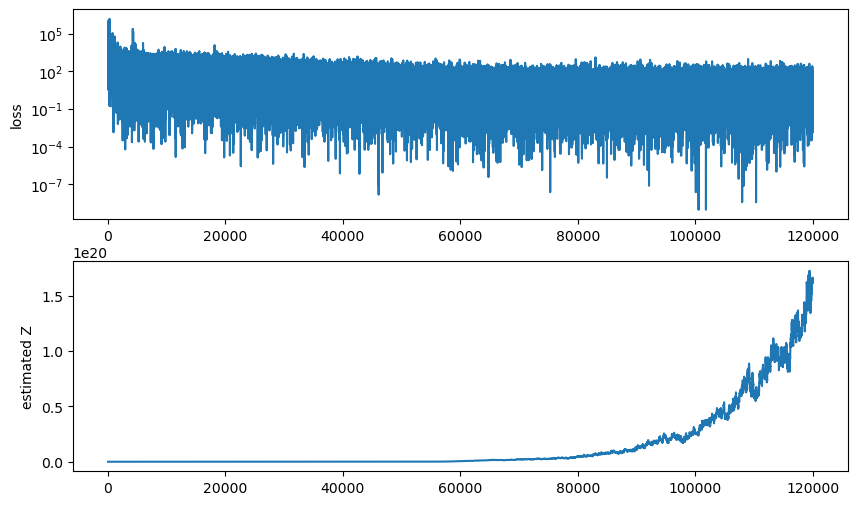

In [6]:
# Instantiate model and optimizer
model = TBModel(256).to(device)
opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses and the TM configuration we sample
tb_losses = []
logZs = []
tb_reward = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0.0
update_freq = 1

for episode in tqdm.tqdm(range(120000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32, device=device)

  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = torch.tensor(0.0, device=device)
  total_P_B = torch.tensor(0.0, device=device)

  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      # If we've built a complete TM-IRS, we're done, so the reward is > 0
      # (unless the TM is incomplete)
      c_mat, tau0_mat, delta_mat = transform_state_to_time_mats_and_phase_vectorized(new_state)
      reward = compute_total_C(c_mat, tau0_mat, delta_mat, user_locations)
      reward = reward.to(device).float()
      # print(reward.device)
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, then compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss
  tb_reward.append(reward.item())

  # If we are at an update episode, take a gradient step.
  if episode % update_freq == 0:
    tb_losses.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0.0
    logZs.append(model.logZ.item())


# When saving, use other namse to avoid overriding the original saved model!!!
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': opt.state_dict(),
#     'losses': tb_losses,
#     'logZs': logZs
# }, "tb_checkpoint.pth")


f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs))
plt.ylabel('estimated Z');

100%|███████████████████████████████████████████████████████| 80000/80000 [2:43:51<00:00,  8.14it/s]


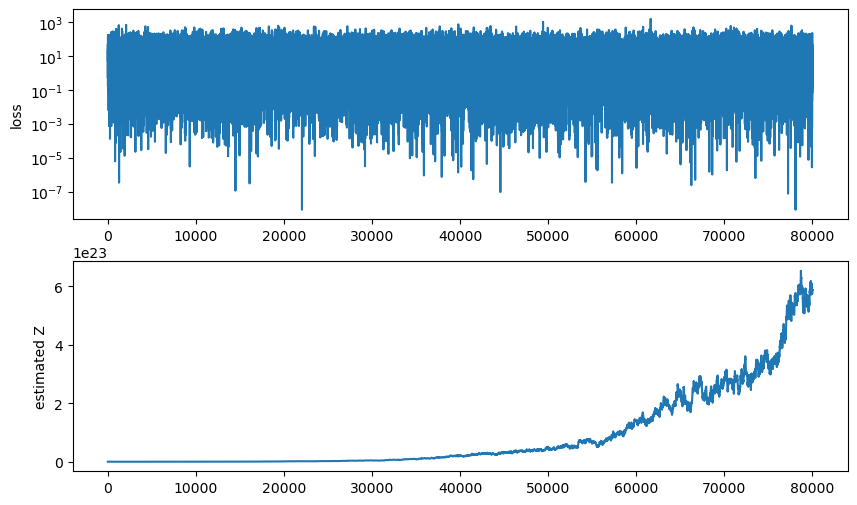

In [8]:

opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses and the TM configuration we sample
tb_losses_1 = []
logZs_1 = []
tb_reward_1 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0.0
update_freq = 1

for episode in tqdm.tqdm(range(80000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32, device=device)

  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = torch.tensor(0.0, device=device)
  total_P_B = torch.tensor(0.0, device=device)

  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      # If we've built a complete TM-IRS, we're done, so the reward is > 0
      # (unless the TM is incomplete)
      c_mat, tau0_mat, delta_mat = transform_state_to_time_mats_and_phase_vectorized(new_state)
      reward = compute_total_C(c_mat, tau0_mat, delta_mat, user_locations)
      reward = reward.to(device).float()
      # print(reward.device)
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, then compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss
  tb_reward_1.append(reward.item())

  # If we are at an update episode, take a gradient step.
  if episode % update_freq == 0:
    tb_losses_1.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0.0
    logZs_1.append(model.logZ.item())


f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_1)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_1))
plt.ylabel('estimated Z');

100%|███████████████████████████████████████████████████████| 50000/50000 [1:39:07<00:00,  8.41it/s]


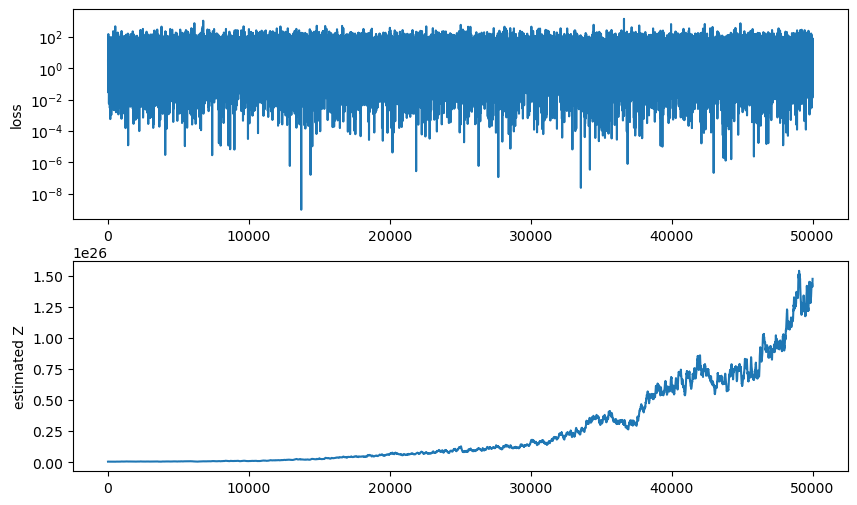

In [14]:

opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses and the TM configuration we sample
tb_losses_2 = []
logZs_2 = []
tb_reward_2 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0.0
update_freq = 1

for episode in tqdm.tqdm(range(50000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32, device=device)

  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = torch.tensor(0.0, device=device)
  total_P_B = torch.tensor(0.0, device=device)

  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      # If we've built a complete TM-IRS, we're done, so the reward is > 0
      # (unless the TM is incomplete)
      c_mat, tau0_mat, delta_mat = transform_state_to_time_mats_and_phase_vectorized(new_state)
      reward = compute_total_C(c_mat, tau0_mat, delta_mat, user_locations)
      reward = reward.to(device).float()
      # print(reward.device)
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, then compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss
  tb_reward_2.append(reward.item())

  # If we are at an update episode, take a gradient step.
  if episode % update_freq == 0:
    tb_losses_2.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0.0
    logZs_2.append(model.logZ.item())


f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_2)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_2))
plt.ylabel('estimated Z');

100%|███████████████████████████████████████████████████████| 80000/80000 [2:34:50<00:00,  8.61it/s]


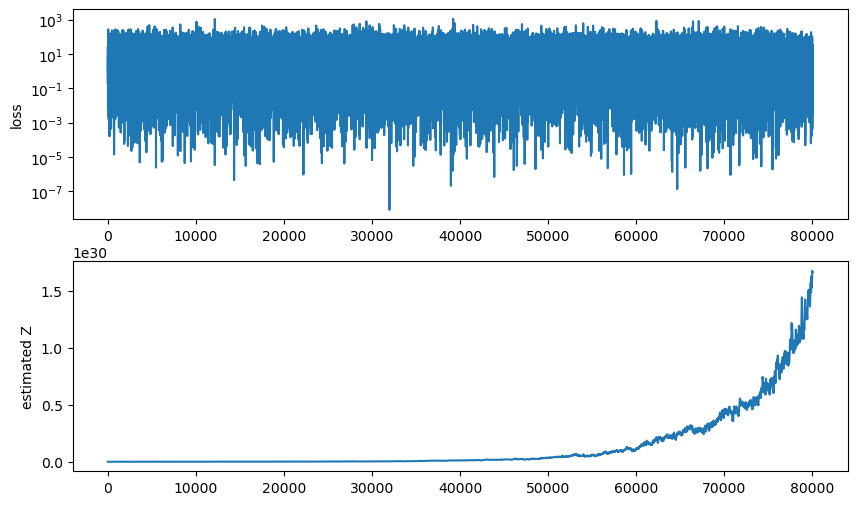

In [17]:

opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses and the TM configuration we sample
tb_losses_3 = []
logZs_3 = []
tb_reward_3 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0.0
update_freq = 1

for episode in tqdm.tqdm(range(80000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32, device=device)

  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = torch.tensor(0.0, device=device)
  total_P_B = torch.tensor(0.0, device=device)

  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      # If we've built a complete TM-IRS, we're done, so the reward is > 0
      # (unless the TM is incomplete)
      c_mat, tau0_mat, delta_mat = transform_state_to_time_mats_and_phase_vectorized(new_state)
      reward = compute_total_C(c_mat, tau0_mat, delta_mat, user_locations)
      reward = reward.to(device).float()
      # print(reward.device)
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, then compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss
  tb_reward_3.append(reward.item())

  # If we are at an update episode, take a gradient step.
  if episode % update_freq == 0:
    tb_losses_3.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0.0
    logZs_3.append(model.logZ.item())


f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_3)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_3))
plt.ylabel('estimated Z');

100%|████████████████████████████████████████████████████| 370000/370000 [11:31:54<00:00,  8.91it/s]


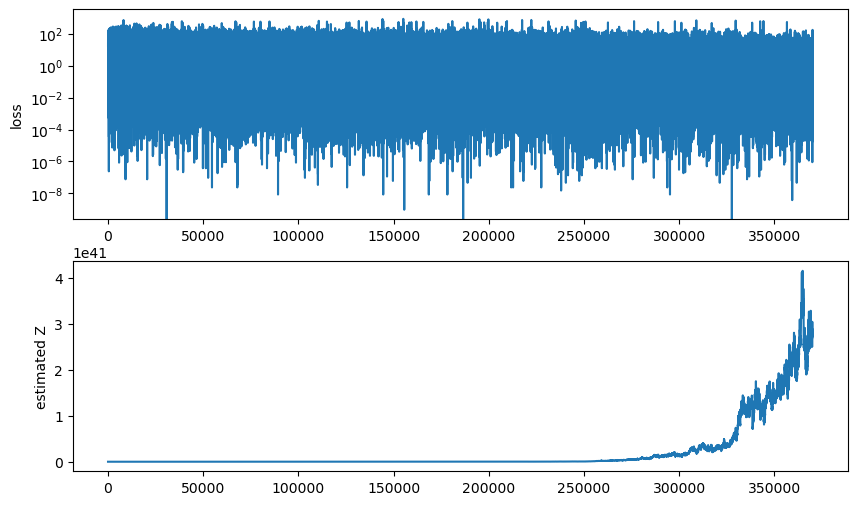

In [19]:

opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses and the TM configuration we sample
tb_losses_4 = []
logZs_4 = []
tb_reward_4 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0.0
update_freq = 1

for episode in tqdm.tqdm(range(370000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32, device=device)

  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = torch.tensor(0.0, device=device)
  total_P_B = torch.tensor(0.0, device=device)

  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      # If we've built a complete TM-IRS, we're done, so the reward is > 0
      # (unless the TM is incomplete)
      c_mat, tau0_mat, delta_mat = transform_state_to_time_mats_and_phase_vectorized(new_state)
      reward = compute_total_C(c_mat, tau0_mat, delta_mat, user_locations)
      reward = reward.to(device).float()
      # print(reward.device)
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, then compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss
  tb_reward_4.append(reward.item())

  # If we are at an update episode, take a gradient step.
  if episode % update_freq == 0:
    tb_losses_4.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0.0
    logZs_4.append(model.logZ.item())


f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_4)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_4))
plt.ylabel('estimated Z');

100%|█████████████████████████████████████████████████████| 100000/100000 [3:12:03<00:00,  8.68it/s]


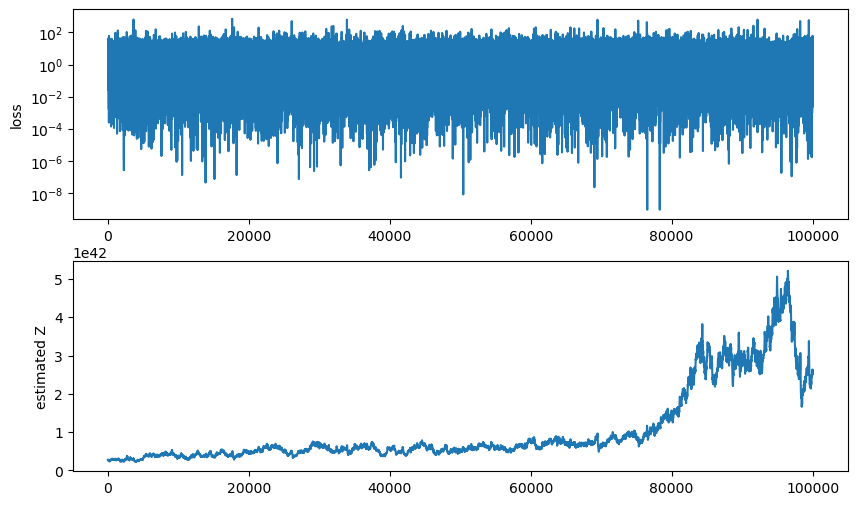

In [26]:

opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses and the TM configuration we sample
tb_losses_5 = []
logZs_5 = []
tb_reward_5 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0.0
update_freq = 1

for episode in tqdm.tqdm(range(100000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32, device=device)

  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = torch.tensor(0.0, device=device)
  total_P_B = torch.tensor(0.0, device=device)

  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      # If we've built a complete TM-IRS, we're done, so the reward is > 0
      # (unless the TM is incomplete)
      c_mat, tau0_mat, delta_mat = transform_state_to_time_mats_and_phase_vectorized(new_state)
      reward = compute_total_C(c_mat, tau0_mat, delta_mat, user_locations)
      reward = reward.to(device).float()
      # print(reward.device)
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, then compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss
  tb_reward_5.append(reward.item())

  # If we are at an update episode, take a gradient step.
  if episode % update_freq == 0:
    tb_losses_5.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0.0
    logZs_5.append(model.logZ.item())


f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_5)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_5))
plt.ylabel('estimated Z');

100%|███████████████████████████████████████████████████████| 50000/50000 [1:37:37<00:00,  8.54it/s]


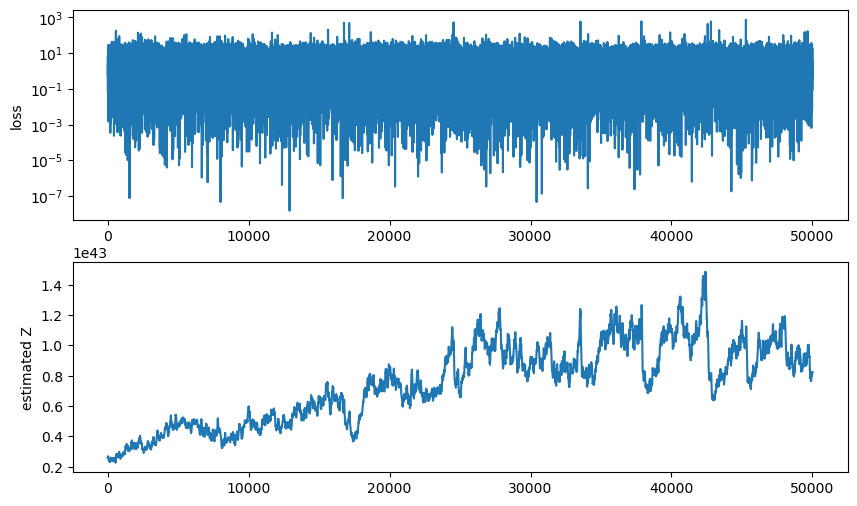

In [30]:

opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses and the TM configuration we sample
tb_losses_6 = []
logZs_6 = []
tb_reward_6 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0.0
update_freq = 1

for episode in tqdm.tqdm(range(50000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32, device=device)

  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = torch.tensor(0.0, device=device)
  total_P_B = torch.tensor(0.0, device=device)

  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      # If we've built a complete TM-IRS, we're done, so the reward is > 0
      # (unless the TM is incomplete)
      c_mat, tau0_mat, delta_mat = transform_state_to_time_mats_and_phase_vectorized(new_state)
      reward = compute_total_C(c_mat, tau0_mat, delta_mat, user_locations)
      reward = reward.to(device).float()
      # print(reward.device)
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, then compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss
  tb_reward_6.append(reward.item())

  # If we are at an update episode, take a gradient step.
  if episode % update_freq == 0:
    tb_losses_6.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0.0
    logZs_6.append(model.logZ.item())


f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_6)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_6))
plt.ylabel('estimated Z');

100%|███████████████████████████████████████████████████████| 50000/50000 [1:37:58<00:00,  8.51it/s]


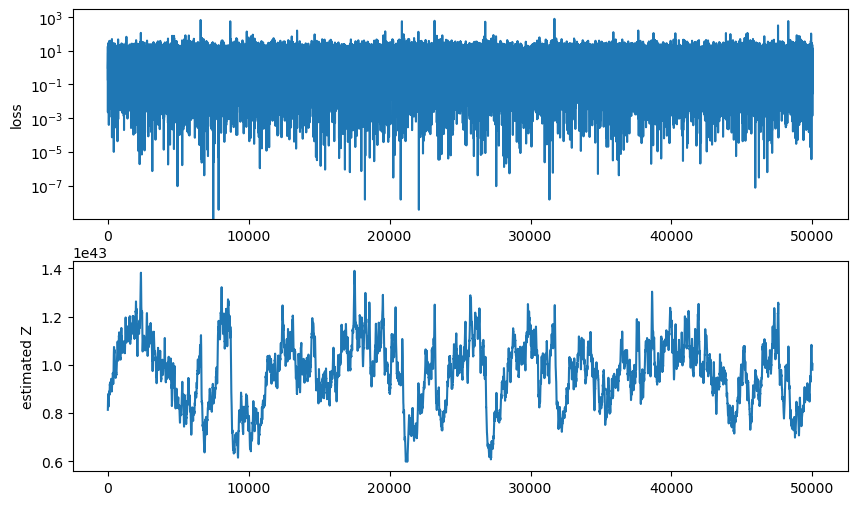

In [33]:

opt = torch.optim.Adam(model.parameters(),  1e-2)

# Let's keep track of the losses and the TM configuration we sample
tb_losses_7 = []
logZs_7 = []
tb_reward_7 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0.0
update_freq = 1

for episode in tqdm.tqdm(range(50000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32, device=device)

  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = torch.tensor(0.0, device=device)
  total_P_B = torch.tensor(0.0, device=device)

  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      # If we've built a complete TM-IRS, we're done, so the reward is > 0
      # (unless the TM is incomplete)
      c_mat, tau0_mat, delta_mat = transform_state_to_time_mats_and_phase_vectorized(new_state)
      reward = compute_total_C(c_mat, tau0_mat, delta_mat, user_locations)
      reward = reward.to(device).float()
      # print(reward.device)
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, then compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss
  tb_reward_7.append(reward.item())

  # If we are at an update episode, take a gradient step.
  if episode % update_freq == 0:
    tb_losses_7.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0.0
    logZs_7.append(model.logZ.item())


f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_7)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_7))
plt.ylabel('estimated Z');

100%|█████████████████████████████████████████████████████| 100000/100000 [3:17:08<00:00,  8.45it/s]


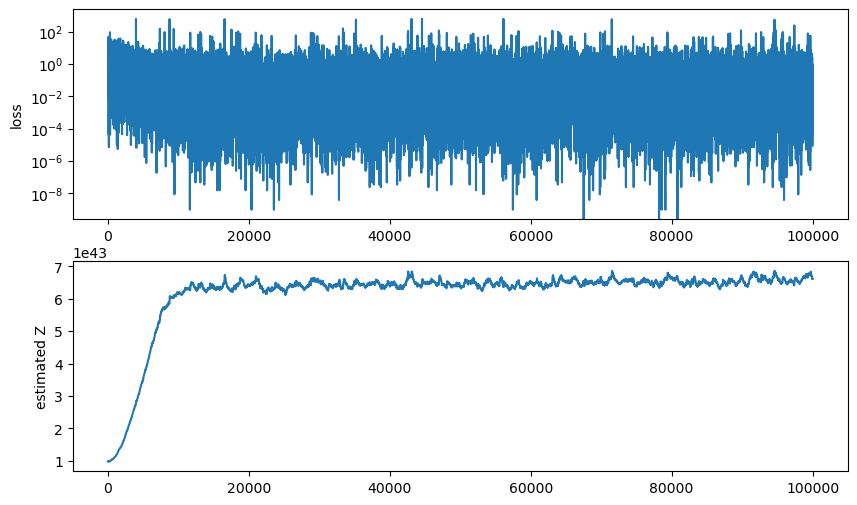

In [36]:

opt = torch.optim.Adam(model.parameters(),  1e-3)

# Let's keep track of the losses and the TM configuration we sample
tb_losses_8 = []
logZs_8 = []
tb_reward_8 = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0.0
update_freq = 1

for episode in tqdm.tqdm(range(100000), ncols=100):
  # Each episode starts with an "empty state"
  state = torch.zeros(input_num, dtype=torch.float32, device=device)

  # Predict P_F, P_B
  P_F_s, P_B_s = model(state)
  total_P_F = torch.tensor(0.0, device=device)
  total_P_B = torch.tensor(0.0, device=device)

  for t in range(trajectory_num):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state.clone()
    new_state[action] = 1.0
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == trajectory_num-1:
      # If we've built a complete TM-IRS, we're done, so the reward is > 0
      # (unless the TM is incomplete)
      c_mat, tau0_mat, delta_mat = transform_state_to_time_mats_and_phase_vectorized(new_state)
      reward = compute_total_C(c_mat, tau0_mat, delta_mat, user_locations)
      reward = reward.to(device).float()
      # print(reward.device)
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(new_state)
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, then compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clamp(min=-20, max=100) - total_P_B).pow(2)
  minibatch_loss += loss
  tb_reward_8.append(reward.item())

  # If we are at an update episode, take a gradient step.
  if episode % update_freq == 0:
    tb_losses_8.append(minibatch_loss.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0.0
    logZs_8.append(model.logZ.item())


f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(tb_losses_8)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs_8))
plt.ylabel('estimated Z');

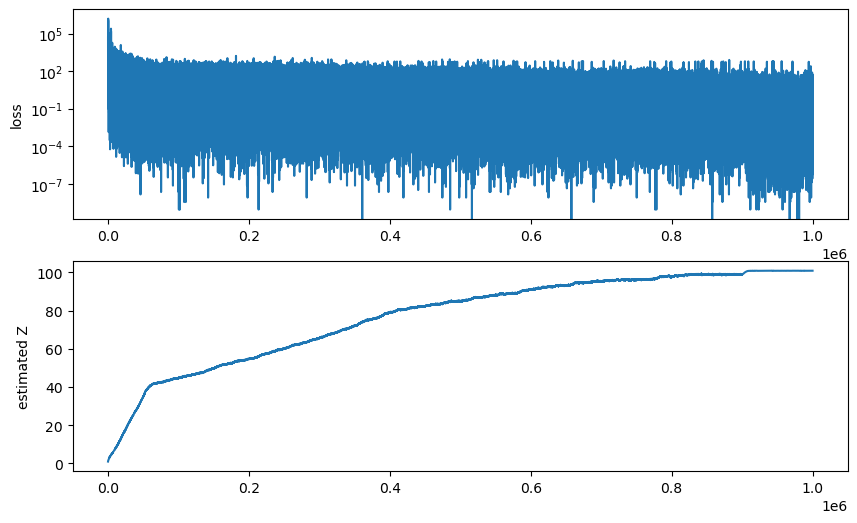

In [37]:
all_losses = np.concatenate([
    tb_losses,
    tb_losses_1,
    tb_losses_2,
    tb_losses_3,
    tb_losses_4,
    tb_losses_5,
    tb_losses_6,
    tb_losses_7,
    tb_losses_8
])

all_logZs = np.concatenate([
    logZs,
    logZs_1,
    logZs_2,
    logZs_3,
    logZs_4,
    logZs_5,
    logZs_6,
    logZs_7,
    logZs_8
])

f, ax = plt.subplots(2, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(all_losses)
plt.yscale('log')
plt.ylabel('loss')
plt.sca(ax[1])
plt.plot(all_logZs)
# plt.plot(np.exp(all_logZs))
plt.ylabel('estimated Z');

In [8]:
###############################################################################
# For computing SER
# QPSK Modulation / Demodulation
###############################################################################
# We use Gray-like labeling, but any consistent mapping works.
qpsk_map = np.array([
    (1+1j) / np.sqrt(2),
    (1-1j) / np.sqrt(2),
    (-1+1j) / np.sqrt(2),
    (-1-1j) / np.sqrt(2)
], dtype=complex)

def qpsk_demap(symbols):
    """
    Hard-decision QPSK demapper: finds the closest constellation point index
    for each symbol in 'symbols'.
    symbols shape = (K, Nsym).
    """
    const = qpsk_map.reshape((1, 4))  # shape (1, 4)
    # We'll return an array of indices in {0,1,2,3}
    out = np.zeros(symbols.shape, dtype=int)
    for col_idx in range(symbols.shape[1]):
        # shape => (K, 1) - (K, 4) => broadcast => get distances
        dist = np.abs(symbols[:, [col_idx]] - const)  # shape (K,4)
        out[:, col_idx] = np.argmin(dist, axis=1)
    return out


def build_toeplitz(v_):
    """
    Given v_ (length 2K-1), build the KxK Toeplitz matrix V.
    - First row = {v0, v_{-1}, ..., v_{-K+1}}
    - First col = {v0, v1, ..., v_{K-1}}
    Implementation detail:
      v_[K-1] = v_0
      row0 = v_[K-1::-1]  # reversed portion
      col0 = v_[K-1:   ]  # forward portion
    """
    # v_[K-1] corresponds to h = 0
    row0 = v_[K-1::-1]  # from h=0 down to h=-K+1
    col0 = v_[K-1:]     # from h=0 up to h=K-1
    return toeplitz(col0, row0)


def compute_SER(theta_deg, phi_deg, c_mat, tau0_mat, delta_mat, Nsym=200):
    # Build the Toeplitz mixing matrix V
    v_ = build_v(theta_deg, phi_deg, c_mat, tau0_mat, delta_mat)
    v_numpy = v_.cpu().numpy()
    V_ = build_toeplitz(v_numpy)

    # Generate random QPSK symbols
    data_int = rnd.randint(0, 4, size=(K, Nsym))  # each entry in {0,1,2,3}
    d_ = qpsk_map[data_int]                       # map to complex points

    # Compute noise-free signal
    factor_ = np.sqrt(N_t / K)
    # y_noiseless shape => (K, Nsym)
    y_noiseless = beta * factor_ * (V_ @ d_)

    noise = noise_std * (rnd.randn(K, Nsym) + 1j * rnd.randn(K, Nsym))
    y_noisy = y_noiseless + noise

    # Hard-decision detection
    detected_int = qpsk_demap(y_noisy)

    # SER
    errors = np.sum(detected_int != data_int)
    SER_ = errors / (K * Nsym)
    return SER_

In [9]:
def compute_total_C_1(c_mat, tau0_mat, delta_mat, user_locs):
    """
    Returns:
        totalC = sum(C_u) * H(min(C_u - C_threshold)) * H(min(pi/5 - |phase_u|))
    """

    C_vals = []
    phase_vals = []


    for (theta_u, phi_u) in user_locs:
        C_val, phase_v0 = compute_user_C(c_mat, tau0_mat, delta_mat, theta_u, phi_u)
        C_vals.append(C_val)
        phase_vals.append(phase_v0)


    C_vals = torch.stack(C_vals)           # shape (num_users,)
    phase_vals = torch.stack(phase_vals)   # shape (num_users,)
    # Heaviside-like masks
    # H1 = (torch.min(C_vals - 55) > 0).float()
    H1 = 1
    H2 = (torch.min(35*np.pi/180 - torch.abs(phase_vals)) > 0).float()
    # H2 = 1

    totalC = torch.sum(C_vals) * H1 * H2

    return totalC

In [96]:
N_mc = 20000
bestC_sum = -1e9
best_c_mat = None
best_tau0  = None
best_delta = None


for i in range(N_mc):
    # Each episode starts with an "empty state"
    state = torch.zeros(input_num, dtype=torch.float32, device=device)
    # Predict P_F, P_B
    P_F_s, P_B_s = model(state)
    
    temperature = max(0.5, 1.0 - i / N_mc)  # <1 -> more exploitation; =0^+ -> Pure exploitation (greedy); =1 -> Standard softmax/Balanced behavior; >1 -> More exploration (randomness)
    # temperature = 1


    for t in range(trajectory_num):
        # Here P_F is logits, so we want the Categorical to compute the softmax for us
        # cat = Categorical(logits=P_F_s)
        cat = Categorical(logits=P_F_s/temperature)
        
        action = cat.sample()
        # "Go" to the next state
        new_state = state.clone()
        new_state[action] = 1.0

        # We recompute P_F and P_B for new_state
        P_F_s, P_B_s = model(new_state)

        # Continue iterating
        state = new_state
    
    c_candidate, tau0_candidate, delta_candidate = transform_state_to_time_mats_and_phase_vectorized(state)
    
    
    total_C = compute_total_C_1(c_candidate, tau0_candidate, delta_candidate, user_locations)
    # reward = torch.log(total_C).clamp(min=-20, max=100)
    # print(reward)
    if total_C > bestC_sum:
        bestC_sum = total_C
        best_c = c_candidate.clone()
        best_tau0 = tau0_candidate.clone()
        best_delta = delta_candidate.clone()
        
    
    if (i + 1) % 100 == 0:
        print(f" Iter {(i+1)}/{N_mc}: current bestC_sum = {bestC_sum:.4f}")


 Iter 100/20000: current bestC_sum = 0.0000
 Iter 200/20000: current bestC_sum = 84.0678
 Iter 300/20000: current bestC_sum = 84.0678
 Iter 400/20000: current bestC_sum = 84.0678
 Iter 500/20000: current bestC_sum = 89.5247
 Iter 600/20000: current bestC_sum = 89.5247
 Iter 700/20000: current bestC_sum = 89.5247
 Iter 800/20000: current bestC_sum = 89.5247
 Iter 900/20000: current bestC_sum = 89.5247
 Iter 1000/20000: current bestC_sum = 89.5247
 Iter 1100/20000: current bestC_sum = 89.5247
 Iter 1200/20000: current bestC_sum = 89.5247
 Iter 1300/20000: current bestC_sum = 94.7076
 Iter 1400/20000: current bestC_sum = 101.7906
 Iter 1500/20000: current bestC_sum = 101.7906
 Iter 1600/20000: current bestC_sum = 101.7906
 Iter 1700/20000: current bestC_sum = 101.7906
 Iter 1800/20000: current bestC_sum = 101.7906
 Iter 1900/20000: current bestC_sum = 101.7906
 Iter 2000/20000: current bestC_sum = 101.7906
 Iter 2100/20000: current bestC_sum = 101.7906
 Iter 2200/20000: current bestC_sum 

In [ ]:
# np.savez('best_params_1 (Q3=16,Q1=Q2=8).npz', c_mat=best_c, tau0=best_tau0, delta=best_delta)

In [ ]:
data = np.load('best_params_1 (Q3=16,Q1=Q2=8).npz')
best_c = torch.from_numpy(data['c_mat'])
best_tau0 = torch.from_numpy(data['tau0'])
best_delta = torch.from_numpy(data['delta'])

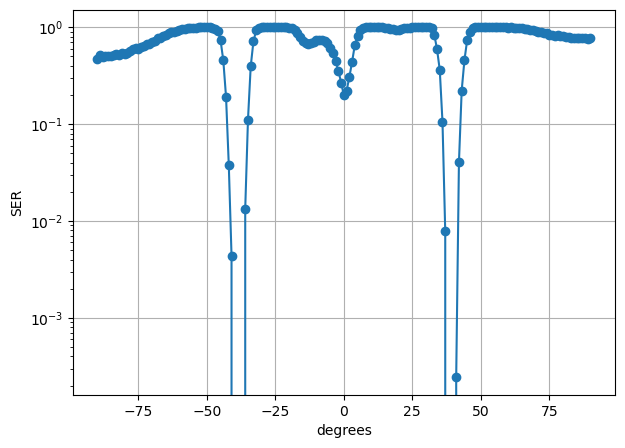

In [33]:
phi_fixed = phi_c
theta_list = np.arange(-90, 91, 1)
SER_vals = np.zeros_like(theta_list, dtype=float)

SER_vals = Parallel(n_jobs=-1)(
    delayed(compute_SER)(th, phi_fixed, best_c, best_tau0, best_delta, Nsym=256)
    for th in theta_list
    )
    
SER_vals = np.array(SER_vals)


# Step C: Plot the SER vs. Theta
plt.figure(figsize=(7,5))
plt.plot(theta_list, SER_vals, 'o-')
plt.xlabel("degrees")
plt.ylabel("SER")
plt.grid(True)
plt.yscale('log')
plt.grid(True)
plt.show()



In [20]:
data1 = np.load('rule_based.npz')
SER_vals_0 = data1['SER_vals']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


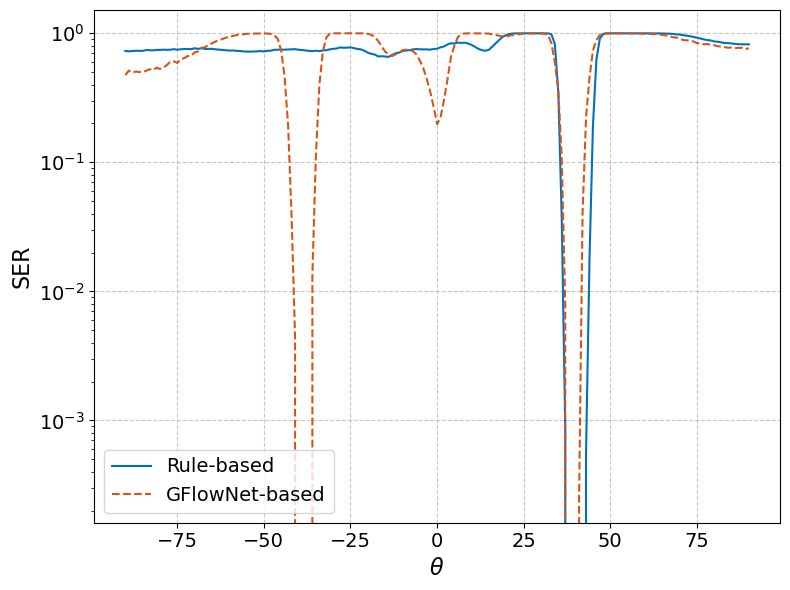

In [34]:
matlab_colors = ['#0072BD', '#D95319', '#EDB120', '#7E2F8E', '#77AC30', '#4DBEEE', '#A2142F']
line_styles = ['-', '--', '-.', '-']

# Load all SER_vals
phi_fixed = 30
theta_list = np.arange(-90, 91, 1)
SER_vals_list = []


SER_vals_list.append(SER_vals_0)
SER_vals_list.append(SER_vals)
labels = ['Rule-based', 'GFlowNet-based']

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

for i, SER_vals in enumerate(SER_vals_list):
    ax.semilogy(theta_list, SER_vals,
            # label=f'SER-{i+1}',
            label=labels[i],
            linewidth=1.5,
            linestyle=line_styles[i % len(line_styles)],
            color=matlab_colors[i % len(matlab_colors)]
           )

# Grid
ax.grid(True, linestyle='--', alpha=0.7)

# Axis labels
ax.set_xlabel(r'$\theta$', fontsize=16)
ax.set_ylabel('SER', fontsize=16)

# Tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Legend
ax.legend(fontsize=14, loc='lower left')

# Save
plt.savefig('f6.eps', format='eps', bbox_inches='tight')

plt.tight_layout()
plt.show()
